In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import pickle
import random
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
images = []
classNo = []
classes = 4
labelFile = 'labels.csv'
current_path = os.getcwd()
epochs_val = 25
batch_size_val = 32
imageDimensions = (224,224,3)
testRatio = 0.1
validationRatio = 0.2

In [5]:
current_path = ""

In [6]:
for cls in range(classes):
    path = os.path.join(current_path,'dataset',str(cls))
    img = os.listdir(path)

    for im in img:
        try:
            image = Image.open(path + '/'+ im)
            image = image.resize((224,224))
            image = np.array(image)
            
            images.append(image)
            classNo.append(cls)
        except:
            print("Error loading image")

In [7]:
images = np.array(images)
classNo = np.array(classNo)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio, random_state=28)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio, random_state=28)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_validation.shape, y_validation.shape)

(3036, 224, 224, 3) (422, 224, 224, 3) (3036,) (422,) (759, 224, 224, 3) (759,)


In [9]:
data = pd.read_csv(labelFile)
print("data shape ", data.shape,type(data))

data shape  (4, 2) <class 'pandas.core.frame.DataFrame'>


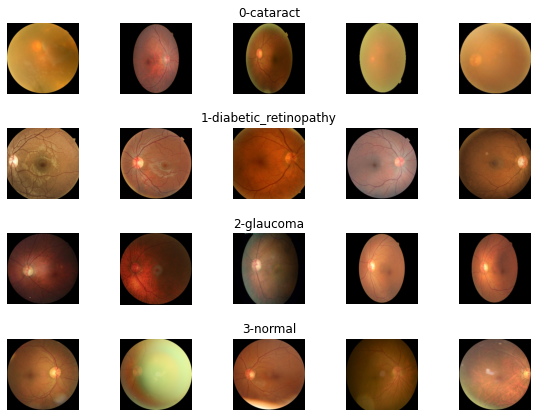

In [10]:
num_of_samples = []
cols = 5
fig, axs = plt.subplots(nrows = classes, ncols = cols, figsize = (8, 6))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+"-"+row["Name"])
            num_of_samples.append(len(x_selected))

[758, 789, 733, 756]


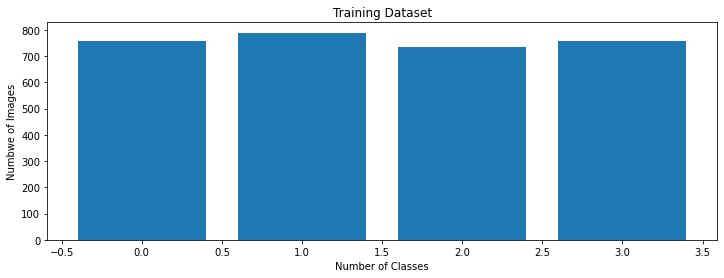

In [11]:
print(num_of_samples)
plt.figure(figsize = (12,4))
plt.bar(range(0, classes), num_of_samples)
plt.title("Training Dataset")
plt.xlabel("Number of Classes")
plt.ylabel("Numbwe of Images")
plt.show()

In [12]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing,X_train)))
X_validation = np.array(list(map(preprocessing,X_validation)))
X_test = np.array(list(map(preprocessing,X_test)))

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [15]:
y_train = to_categorical(y_train, classes)
y_validation = to_categorical(y_validation, classes)
y_test = to_categorical(y_test, classes)

In [16]:
def myModel():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(imageDimensions[0],imageDimensions[1],1)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(4, activation='softmax'))

    #Compilation of the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [17]:
model = myModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 108, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 106, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 104, 104, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 64)        0

In [18]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size_val, 
                    epochs=epochs_val, 
                    validation_data=(X_validation, y_validation))

model.save('model_25_gpu.h5')

Epoch 1/25
95/95 [==============================] - 15s 85ms/step - loss: 1.2124 - accuracy: 0.4493 - val_loss: 0.8318 - val_accuracy: 0.5929
Epoch 2/25
95/95 [==============================] - 6s 66ms/step - loss: 0.7808 - accuracy: 0.6387 - val_loss: 0.7169 - val_accuracy: 0.6772
Epoch 3/25
95/95 [==============================] - 6s 66ms/step - loss: 0.6394 - accuracy: 0.7181 - val_loss: 0.6133 - val_accuracy: 0.7207
Epoch 4/25
95/95 [==============================] - 6s 66ms/step - loss: 0.5141 - accuracy: 0.7816 - val_loss: 0.4717 - val_accuracy: 0.8155
Epoch 5/25
95/95 [==============================] - 6s 66ms/step - loss: 0.4514 - accuracy: 0.8123 - val_loss: 0.5467 - val_accuracy: 0.7681
Epoch 6/25
95/95 [==============================] - 6s 66ms/step - loss: 0.4044 - accuracy: 0.8251 - val_loss: 0.4650 - val_accuracy: 0.7971
Epoch 7/25
95/95 [==============================] - 6s 66ms/step - loss: 0.3136 - accuracy: 0.8696 - val_loss: 0.5044 - val_accuracy: 0.7997
Epoch 8/25
9

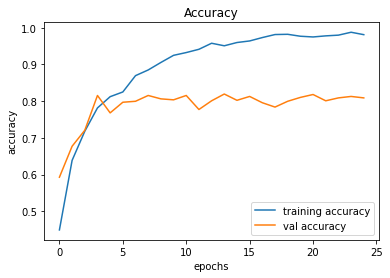

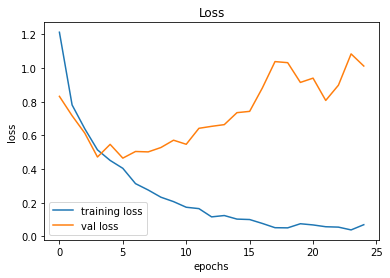

In [19]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', score[1])

Train accuracy: 0.9996706247329712


In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.8080568909645081


In [25]:
pred = np.argmax(model.predict(X_test), axis = 1)

In [24]:
actual=np.argmax(y_test, axis = 1)

In [23]:
label = data["Name"].values
label

array(['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'],
      dtype=object)

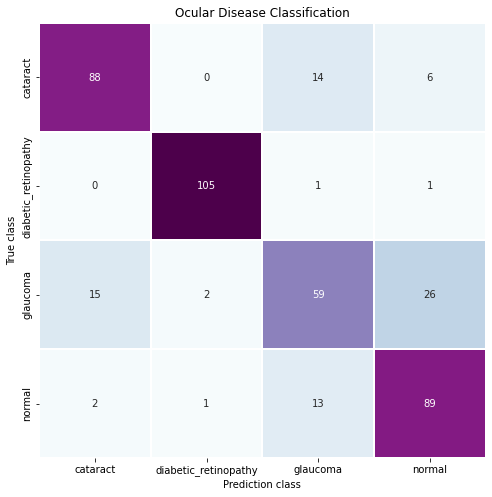

In [30]:
cm = confusion_matrix(actual, pred)
cm_df = pd.DataFrame(cm, index = label, columns = label)

plt.figure(figsize = (8,8))
sns.heatmap(cm_df, annot = True,cmap='BuPu',cbar=False,linewidth=2,fmt='d')
plt.title('Ocular Disease Classification')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

In [31]:
cf = classification_report(actual, pred, target_names = label)
print(cf)

                      precision    recall  f1-score   support

            cataract       0.84      0.81      0.83       108
diabetic_retinopathy       0.97      0.98      0.98       107
            glaucoma       0.68      0.58      0.62       102
              normal       0.73      0.85      0.78       105

            accuracy                           0.81       422
           macro avg       0.80      0.81      0.80       422
        weighted avg       0.81      0.81      0.81       422

